In [6]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Permute,Conv1D, BatchNormalization, GlobalAveragePooling1D, concatenate, Input
from keras.layers import Activation
from keras.layers import Dropout
from keras.models import Model
import pickle
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [7]:
subjectList = pd.read_csv('participantID1.csv', header=None) # import the number participant IDs without the header
numSubjects = subjectList.count()[0]

subjectAlias = np.linspace(1,numSubjects,numSubjects).tolist()
outerSubjectAlias = subjectAlias
trialNames = ['NN','YN','NY','YY'] # NN = NNL + NNH, YN = YNL + YNH, NY = NYL + NHH, YY = YYL + YYH

In [8]:
with open('trajectoryDataFrame_win10_multilabel.pkl', 'rb') as file:
    # Call load method to deserialze
    trajectoryDataFrame = pickle.load(file)
with open('outputDataFrame_win10_multilabel.pkl', 'rb') as file:
    # Call load method to deserialze
    outputDataFrame = pickle.load(file)

In [9]:
def assignUserOutput(dataFrameData, requiredSubjects):
    requiredData = dataFrameData.loc[requiredSubjects].to_numpy()
    return requiredData

def assignUserTraj(dataFrameData, requiredSubjects, featureCombo, requiredFeatureCombo):
    requiredData = np.array([])
    for i in range(len(trajectoryDataFrame)):
        temp = dataFrameData[i].loc[requiredSubjects,featureCombo[requiredFeatureCombo]].to_numpy()
        temp = temp.reshape(temp.shape[0],1,temp.shape[1])
        if i == 0:
            requiredData = temp
        if i != 0 :
            requiredData = np.append(requiredData,temp, axis=1)
    return requiredData

def generate_lstmfcn(numFeatures, seqLength, numCLasses, NUM_CELLS=8):

    #ip = Input(shape=(numFeatures, seqLength))
    ip = Input(shape=(seqLength, numFeatures))
    x = Permute((2, 1))(ip)
    x = LSTM(NUM_CELLS)(x)
    x = Dropout(0.8)(x)

    #y = Permute((2, 1))(ip)
    #y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(ip)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])
    #out = Dense(numCLasses, activation='softmax')(x)
    out = Dense(numCLasses, activation='sigmoid')(x)
    model = Model(ip, out)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)
    #model.compile(loss='categorical_crossentropy',optimizer =optimizer,metrics=['accuracy']) 
    model.compile(loss='BinaryCrossentropy',optimizer =optimizer,metrics=['accuracy']) 
    # model.summary()
    #model.summary()
    # add load model code here to fine-tune
    return model

In [62]:
dropOutRates = 0.3
firstLSTMNodes = 128
secondLSTMNodes = 64
numDenseLayers = 2
miniBatch = 64
numEpochs = 100
featureCombo = [['speed','thetaDot']]

In [76]:
trainFraction = 0.7
np.random.shuffle(outerSubjectAlias)
numTrainData = int(trainFraction*len(outerSubjectAlias))
numTestData = len(outerSubjectAlias) - numTrainData
trainSubjects = outerSubjectAlias[0:numTrainData]
testSubjects = outerSubjectAlias[len(trainSubjects):len(outerSubjectAlias)]



trainTrajData = assignUserTraj(trajectoryDataFrame,trainSubjects, featureCombo, 0)
trainOutputData = assignUserOutput(outputDataFrame,trainSubjects)

testTrajData = assignUserTraj(trajectoryDataFrame,testSubjects, featureCombo, 0)
testOutputData = assignUserOutput(outputDataFrame,testSubjects)

features = trainTrajData.shape[2]
seq_length = trainTrajData.shape[1]
numClasses = trainOutputData.shape[1]

In [77]:
features

2

In [96]:
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Stops training when 98% accuracy is reached
    '''
    # Get the current accuracy and check if it is above 95%
    if(logs.get('val_accuracy') > 0.72 and logs.get('val_loss') < 1 ):

      # Stop training if condition is met
      print("\nThreshold reached. Stopping training...")
      self.model.stop_training = True

# Let's instantiate our ES class
early_stopping = EarlyStopping()

In [97]:
tf.keras.backend.clear_session()
mlModel = generate_lstmfcn(features, seq_length, numClasses, NUM_CELLS=8)
#mlModel = lstmModel(dropOutRates, firstLSTMNodes, secondLSTMNodes, numDenseLayers, features, seq_length, numClasses)

history = mlModel.fit(trainTrajData,trainOutputData,epochs=2000,batch_size=512,validation_data=(testTrajData, testOutputData),verbose=1,callbacks=[early_stopping])

Epoch 1/2000
6/6 [==============================] - 4s 228ms/step - loss: 0.8521 - accuracy: 0.5105 - val_loss: 612.8527 - val_accuracy: 0.6561
Epoch 2/2000
6/6 [==============================] - 1s 139ms/step - loss: 0.7269 - accuracy: 0.5484 - val_loss: 69.7831 - val_accuracy: 0.6554
Epoch 3/2000
6/6 [==============================] - 1s 132ms/step - loss: 0.6883 - accuracy: 0.2959 - val_loss: 12.5387 - val_accuracy: 0.3439
Epoch 4/2000
6/6 [==============================] - 1s 135ms/step - loss: 0.6917 - accuracy: 0.3186 - val_loss: 7.0767 - val_accuracy: 0.6501
Epoch 5/2000
6/6 [==============================] - 1s 135ms/step - loss: 0.6825 - accuracy: 0.3420 - val_loss: 5.2529 - val_accuracy: 0.6501
Epoch 6/2000
6/6 [==============================] - 1s 131ms/step - loss: 0.6830 - accuracy: 0.3483 - val_loss: 0.9744 - val_accuracy: 0.5734
Epoch 7/2000
6/6 [==============================] - 1s 131ms/step - loss: 0.6788 - accuracy: 0.2962 - val_loss: 1.1186 - val_accuracy: 0.3454
Ep

In [98]:
mlModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 2)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 240, 128)             2176      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 240, 128)             512       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 240, 128)             0         ['batch_normalization[0][0

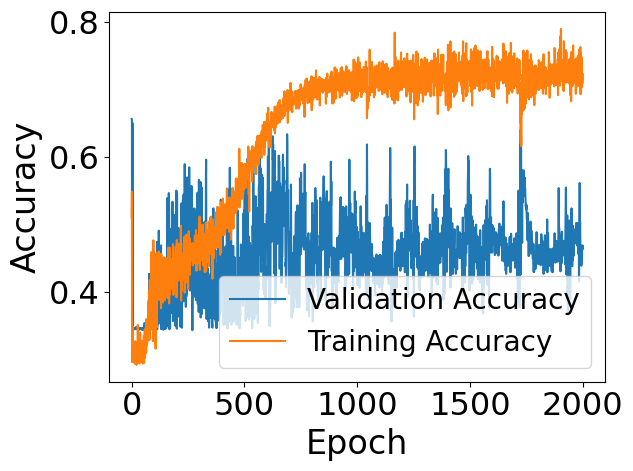

In [99]:
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Accuracy', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.legend(fontsize=20)

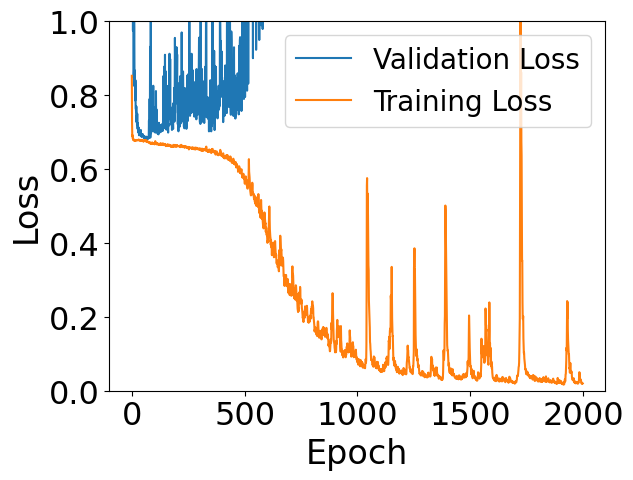

In [101]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Loss', fontsize=24)
plt.ylim((0, 1))
plt.tick_params(axis='both', which='major', labelsize=23)
plt.legend(fontsize=20)

In [102]:
classes = [1,2]
y_prediction = mlModel.predict(testTrajData)
positiveThresholdClass1 = 0.51
y_test = testOutputData
## class1 True values
class1TP = 0
class1TN = 0
class1FP = 0
class1FN = 0
class1P = 0
class1N = 0
for i in range(y_test.shape[0]):
        if(y_prediction[i,0] < positiveThresholdClass1 and y_test[i,0] == 1e-5 ):
            class1TN = class1TN + 1

        if(y_prediction[i,0] < positiveThresholdClass1 and y_test[i,0] == 1-1e-5 ):
            class1FN = class1FN + 1

        if(y_prediction[i,0] >= positiveThresholdClass1 and y_test[i,0] == 1e-5 ):
            class1FP = class1FP + 1

        if(y_prediction[i,0] >= positiveThresholdClass1 and y_test[i,0] == 1-1e-5):
            class1TP = class1TP + 1
        

        
        if( y_test[i,0] ==  1e-5):
             class1N = class1N + 1
        if( y_test[i,0] == 1 -  1e-5):
             class1P = class1P + 1

## class 2 True values
class2TP = 0
class2TN = 0
class2FP = 0
class2FN = 0
class2P = 0
class2N = 0
positiveThresholdClass2 = 0.51
for i in range(y_test.shape[0]):
        if(y_prediction[i,1]  < positiveThresholdClass2 and y_test[i,1] == 1e-5 ):
            class2TN = class2TN + 1

        if(y_prediction[i,1] < positiveThresholdClass2 and y_test[i,1] == 1-1e-5 ):
            class2FN = class2FN + 1

        if(y_prediction[i,1] >= positiveThresholdClass2 and y_test[i,1] == 1e-5 ):
            class2FP = class2FP + 1
        


        if(y_prediction[i,1] >= positiveThresholdClass2 and y_test[i,1] == 1-1e-5):
            class2TP = class2TP + 1

        if( y_test[i,1] ==  1e-5):
            class2P = class2P + 1
        if( y_test[i,1] == 1 -  1e-5):
            class2N = class2N + 1

            
totalClass1 = class1TP + class1FP + class1FN + class1TN
class1Matrix = np.array([[class1TP, class1FP],[class1FN,class1TN]])
class1Matrix = np.divide(class1Matrix, totalClass1)

totalClass2 = class2TP + class2FP + class2FN + class2TN
class2Matrix = np.array([[class2TP, class2FP],[class2FN,class2TN]])
class2Matrix = np.divide(class2Matrix, totalClass2)

distributionMatrix = np.array([[class1P, class2P],[class1N,class2N]])


42/42 [==============================] - 1s 5ms/step


In [103]:
y_prediction

array([[4.5284161e-01, 1.5564342e-01],
       [8.7047696e-01, 9.9983120e-01],
       [6.0730923e-05, 6.4288982e-04],
       ...,
       [1.3938639e-01, 1.4044290e-03],
       [1.8220554e-07, 7.4045871e-05],
       [6.0392753e-03, 9.9746084e-01]], dtype=float32)

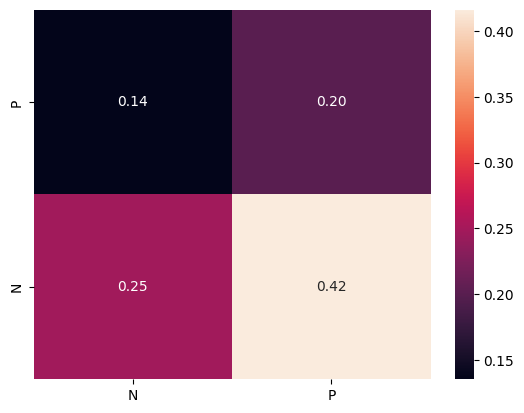

In [104]:
ax = sns.heatmap(class1Matrix, annot=True, fmt=".2f")
ax.set_xticklabels(["N", "P"])
ax.set_yticklabels(["P", "N"])
plt.show()

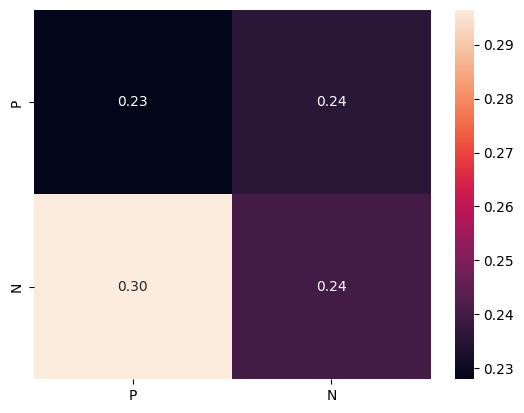

In [105]:
ax = sns.heatmap(class2Matrix, annot=True, fmt=".2f")
ax.set_xticklabels(["P", "N"])
ax.set_yticklabels(["P", "N"])
plt.show()